In [16]:
%matplotlib inline
from pyquil import Program, get_qc
from pyquil.gates import *
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import collections

In [17]:
def live_plot(data_dict, figsize=(7,5), title='Power Rabi'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Pulse duration')
    plt.legend(loc='upper left') # the plot evolves to the right
    plt.show()

In [18]:
def power_rabi(qubit, frame, duration, scale, shots=10000):
    p = Program(f'DECLARE ro BIT',
               'RESET',
               f'SET-SCALE {frame} {scale}', 
               f'PULSE {frame} flat(duration: {duration}e-9, iq: 1.0)',
               f'MEASURE {qubit} ro'
               ).wrap_in_numshots_loop(shots)
    
    print('\nQUIL PROGRAM: ', p)
    
    return p

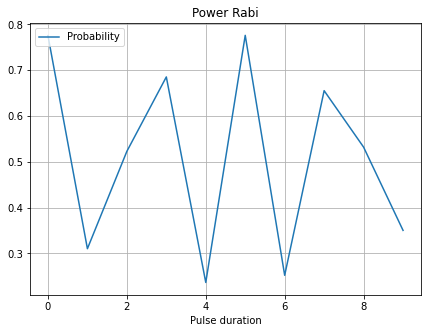


QUIL PROGRAM:  DECLARE ro BIT[1]
RESET
SET-SCALE 7 "rf" 0.5
PULSE 7 "rf" flat(duration: 4.4e-08, iq: 1.0)
MEASURE 7 ro[0]



ReadTimeout: The read operation timed out

In [24]:
shots = 10000
qubit = 7
scale = .5

# live logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
logging.basicConfig(filename='logs/power_rabi.log', 
                    format='%(asctime)s%(msecs)03d - %(message)s', 
                    level=logging.INFO, 
                    datefmt='%d-%b-%y %H:%M:%S.')
logging.info('------------------------------------------------------------------------------   Begin')
logging.info(f'Scale: {scale}')

# get calibrations and frames
qc = get_qc('Aspen-11')
cals = qc.compiler.get_calibration_program()
rf_frames = list(filter(lambda f: f[0].name == "rf", cals.frames.items()))

# save qubit frame and frequency
(frame, frame_def) = rf_frames[qubit]
frequency = frame_def.initial_frequency
print('qubit frame: ', frame, '\tfrequency: ', frequency)

# initialize loop
times = np.linspace(4,100,25) # 25 is around  2 minutes
results = collections.defaultdict(list)

for duration in times:
    
    # compile program and time compilation
    prog = power_rabi(qubit, frame, duration, scale, shots)
    start_compile = time.time()
    exe = qc.compiler.native_quil_to_executable(prog)
    total_compile = time.time() - start_compile
    logging.info(f'Program compiled in {total_compile:.3f} s')
    
    # run program and get runtime
    start_run = time.time()
    # result = qc.run(exe)
    result = qc.run(exe).readout_data.get('ro')
    total_run = time.time() - start_run
    
    # update plot and log
    probability = np.sum(result) / shots
    results['Probability'].append(probability)
    live_plot(results)
    logging.info(f' duration: {duration} \t-- probability: {probability} \t--- runtime: {total_run:.3f} seconds')